# MEDT4165 Deep Learning Exercise - Suggested solution
This notebook contains a suggested solution for the deep learning exercise. It provides some small and larger improvements which should result in a better performing model. Note that this is just one suggestion, but there are many other ways you could have achieved similar, or better performance. The changes that have been implemented are:
- Improved hyperparameter settings: validation split, batch size, number of epochs.
- Improved model architecture: changed from autoencoder to U-Net.
- Changed loss function to dice loss.

The changes are elaborated at the relevant code cells. *Disclaimer*: I have not verified that each one of these changes actually improve the model performance significantly, but based on prior experience these changes should lead to a better model. The end result is nonetheless a model that performs better than the one you were provided with initially.

In [1]:
import os
import shutil
import gdown
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib.colors import Normalize, ListedColormap

# Define a transparent colormap which we'll use for visualization of the segmentation masks
alpha = 0.3  # opacity (30 %)
cmap = ListedColormap([
    (0, 0, 0, 0),  # Class 0 (background) - Fully transparent
    (1, 0, 0, alpha),  # Class 1 (left ventricle) - Red
    (0, 1, 0, alpha),  # Class 2 (left ventricular wall) - Green
    (0, 0, 1, alpha)   # Class 3 (left atrium) - Blue
])

In [2]:
filename = "CAMUS_trainval_dataset.hdf5.zip"
id = "12_XhQALTeAqi3jFL3zQPnaNt-nlZv1UB"
gdown.download(id=id, output=filename, quiet=False)
shutil.unpack_archive(filename, '.', 'zip')

Downloading...
From (original): https://drive.google.com/uc?id=12_XhQALTeAqi3jFL3zQPnaNt-nlZv1UB
From (redirected): https://drive.google.com/uc?id=12_XhQALTeAqi3jFL3zQPnaNt-nlZv1UB&confirm=t&uuid=12792e9b-b3ee-4092-8c4f-3b44c8eabf0a
To: /content/CAMUS_trainval_dataset.hdf5.zip
100%|██████████| 516M/516M [00:08<00:00, 59.4MB/s]


In [3]:
data = h5py.File("./CAMUS_trainval_dataset.hdf5", "r")

N_IMAGES = data["images"].shape[0]
print(data.keys())
print('Number of training + validation images: {}'.format(N_IMAGES))

<KeysViewHDF5 ['images', 'masks']>
Number of training + validation images: 1800


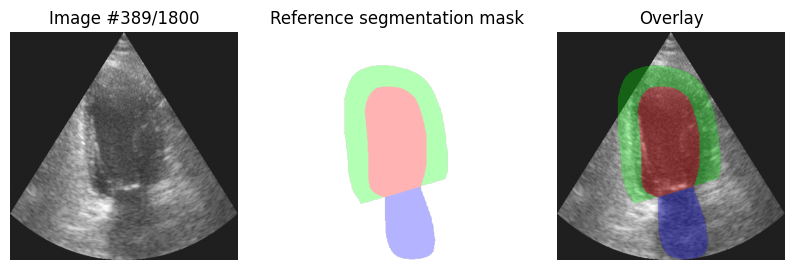

In [4]:
i = np.random.randint(0, N_IMAGES)

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(data["images"][i, ..., 0], cmap='gray')
plt.title(f'Image #{i+1}/{N_IMAGES}')
plt.axis('off')
plt.subplot(132)
plt.imshow(data["masks"][i, ..., 0], cmap=cmap)
plt.title('Reference segmentation mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(data["images"][i, ..., 0], cmap='gray')
plt.imshow(data["masks"][i, ..., 0], cmap=cmap)
plt.title('Overlay')
plt.axis('off')
plt.show()

In [89]:
def dice(y_true, y_pred, skip_background=True, smooth=1e-6, axis=(0,1,2)):
    """
    Implements the Dice Coefficient between two from one-hot encoded tensors `y_true` and `y_pred`.
    If the background class is included in the tensors it must be skipped using `skip_background=True`, otherwise the dice coefficient will be incorrectly calculated.
    The "smooth" parameter prevents division by zero.
    axis specifies the axis for which the computation is averaged over. Default is (0,1,2), which gives one value per class (dimension 3)
    """

    assert y_true.ndim == y_pred.ndim == 4, "Incorrect number of dimensions. Expected 4 (batch, height, width, channels)"

    if skip_background:
        y_true = y_true[..., 1:]
        y_pred = y_pred[..., 1:]

    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axis) + smooth
    union = tf.math.reduce_sum(y_true, axis=axis) + tf.math.reduce_sum(y_pred, axis=axis) + smooth
    return 2 * intersection / union

def normalize(img):
  minval = tf.math.reduce_min(img)
  maxval = tf.math.reduce_max(img)
  return (img - minval) / (maxval - minval)

def to_categorical(mask):
    """Convert one-hot encoded mask to categorical mask for visualization."""
    return np.argmax(mask, axis=-1)

# Create synchronized augmentation layers such that the same augments are applied to images and masks
rotation_layer_image = tf.keras.layers.RandomRotation(0.1, seed=42, fill_mode='constant')
rotation_layer_mask = tf.keras.layers.RandomRotation(0.1, seed=42, fill_mode='constant')
translation_layer_image = tf.keras.layers.RandomTranslation(0.1, 0.1, seed=42, fill_mode='constant')
translation_layer_mask = tf.keras.layers.RandomTranslation(0.1, 0.1, seed=42, fill_mode='constant')


def augment_images(image, mask):


    image = rotation_layer_image(image)
    mask = rotation_layer_mask(mask)

    image = translation_layer_image(image)
    mask = translation_layer_mask(mask)

    # Brightness/contrast (only for image)
    image = tf.image.adjust_gamma(image, gamma=tf.random.uniform([], 0.5, 1.5))

    # Add gaussian Noise (only for image)
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=tf.random.uniform([], 0.0, 0.2))
    image = image + noise

    # Handle NaN values
    image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))

    return image, mask

# Generator function
def data_generator(images, masks, image_size, use_augments):
    """Generator function to load image-mask pairs from HDF5 dataset."""
    assert image_size[0] <= images.shape[1] and image_size[1] <= images.shape[2], "IMAGE_SIZE cannot be larger than the original image size."

    for i in range(len(images)):

        img = images[i]
        mask = masks[i]

        # Encode masks from categorical (1,2,3) to binary values (One-hot encoding)
        mask = tf.cast(mask, tf.uint8)  # Convert resized mask to integer values
        mask = tf.squeeze(mask, axis=-1)  # Remove unnecessary last dimension
        mask = tf.one_hot(mask, depth=4)  # One-hot encode mask with 3 classes + background

        # Resize images
        img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
        mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        # Apply data augmentation
        if use_augments:
            img, mask = augment_images(img, mask)

        # Normalize images to [0,1]
        img = normalize(img)

        # Binarize masks
        mask = tf.cast(mask > 0.5, tf.float32)

        yield img, mask


# Wrap the generator with tf.data.Dataset
def get_tf_dataset(images, masks, batch_size=32, image_size=(128,128), shuffle=True, use_augments=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(images, masks, image_size, use_augments),
        output_signature=(
            tf.TensorSpec(shape=(*image_size, 1), dtype=tf.float32),  # Image shape
            tf.TensorSpec(shape=(*image_size, 4), dtype=tf.float32)  # Mask shape
        )
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


## Hyperparameter improvements

We can improve the model performance quite a bit by adjusting the hyperparameters:

Importantly, we can reduce the *validation split* from 0.5 to 0.2. This means that we will use 80% of the training data for training, and 20% for validation. This is important, as we want to train the model on as much data as possible. The trade-off is that we will have less data to validate the model on.

I will increase the *batch size* as to 64. This will speed up the training process, but it will also require more memory. You can try to play around with this value and see how it affects the training time and performance. A larger batch size can lead to a more stable training process, i.e. smoother loss curves. (Based on experience the batch size is typically not as important as the other hyperparameters for these ML tasks).

The learning rate is kept as it was. It is also possible to do more fancy strategies, like decreasing the learning rate over time, such that the model learns a lot in the beginning and then makes small improvements in the end. By the way, it is also possible to choose from other *optimizers*, such as the stochastic gradient descent (SGD) optimizer, but in practice everyone always uses Adam, as there seems to be consensus that this is the best one.

Finally, we can increase the *number of epochs* from 5 to 25. This will allow the model to train for longer and learn more from the data. However, it will also take longer to train the model. You can try to play around with this value and see how it affects the training time and performance.

In [108]:
VALIDATION_SPLIT = 0.2 # was 0.5

IMAGE_SIZE = [128, 128] # left as it was
BATCH_SIZE = 64 # was 16

# Compute number of images in each set given validation split fraction
N_VAL = int(N_IMAGES * VALIDATION_SPLIT)
N_TRAIN = N_IMAGES - N_VAL

# Clear any datasets in memory
K.clear_session()

# Create TensorFlow datasets (use first N_VAL elements for validation)
train_dataset = get_tf_dataset(data["images"][N_VAL:], data["masks"][N_VAL:], batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, use_augments=False)
val_dataset = get_tf_dataset(data["images"][:N_VAL], data["masks"][:N_VAL], batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, use_augments=False) # We don't want to augment the validation images

# Verify dataset structure
for img, mask in val_dataset.take(1):
    print("Image batch shape:", img.shape, "Min:", np.min(img), "Max:", np.max(img))
    print("Mask batch shape:", mask.shape, "Min:", np.min(mask), "Max:", np.max(mask))

Image batch shape: (64, 128, 128, 1) Min: 0.0 Max: 1.0
Mask batch shape: (64, 128, 128, 4) Min: 0.0 Max: 1.0


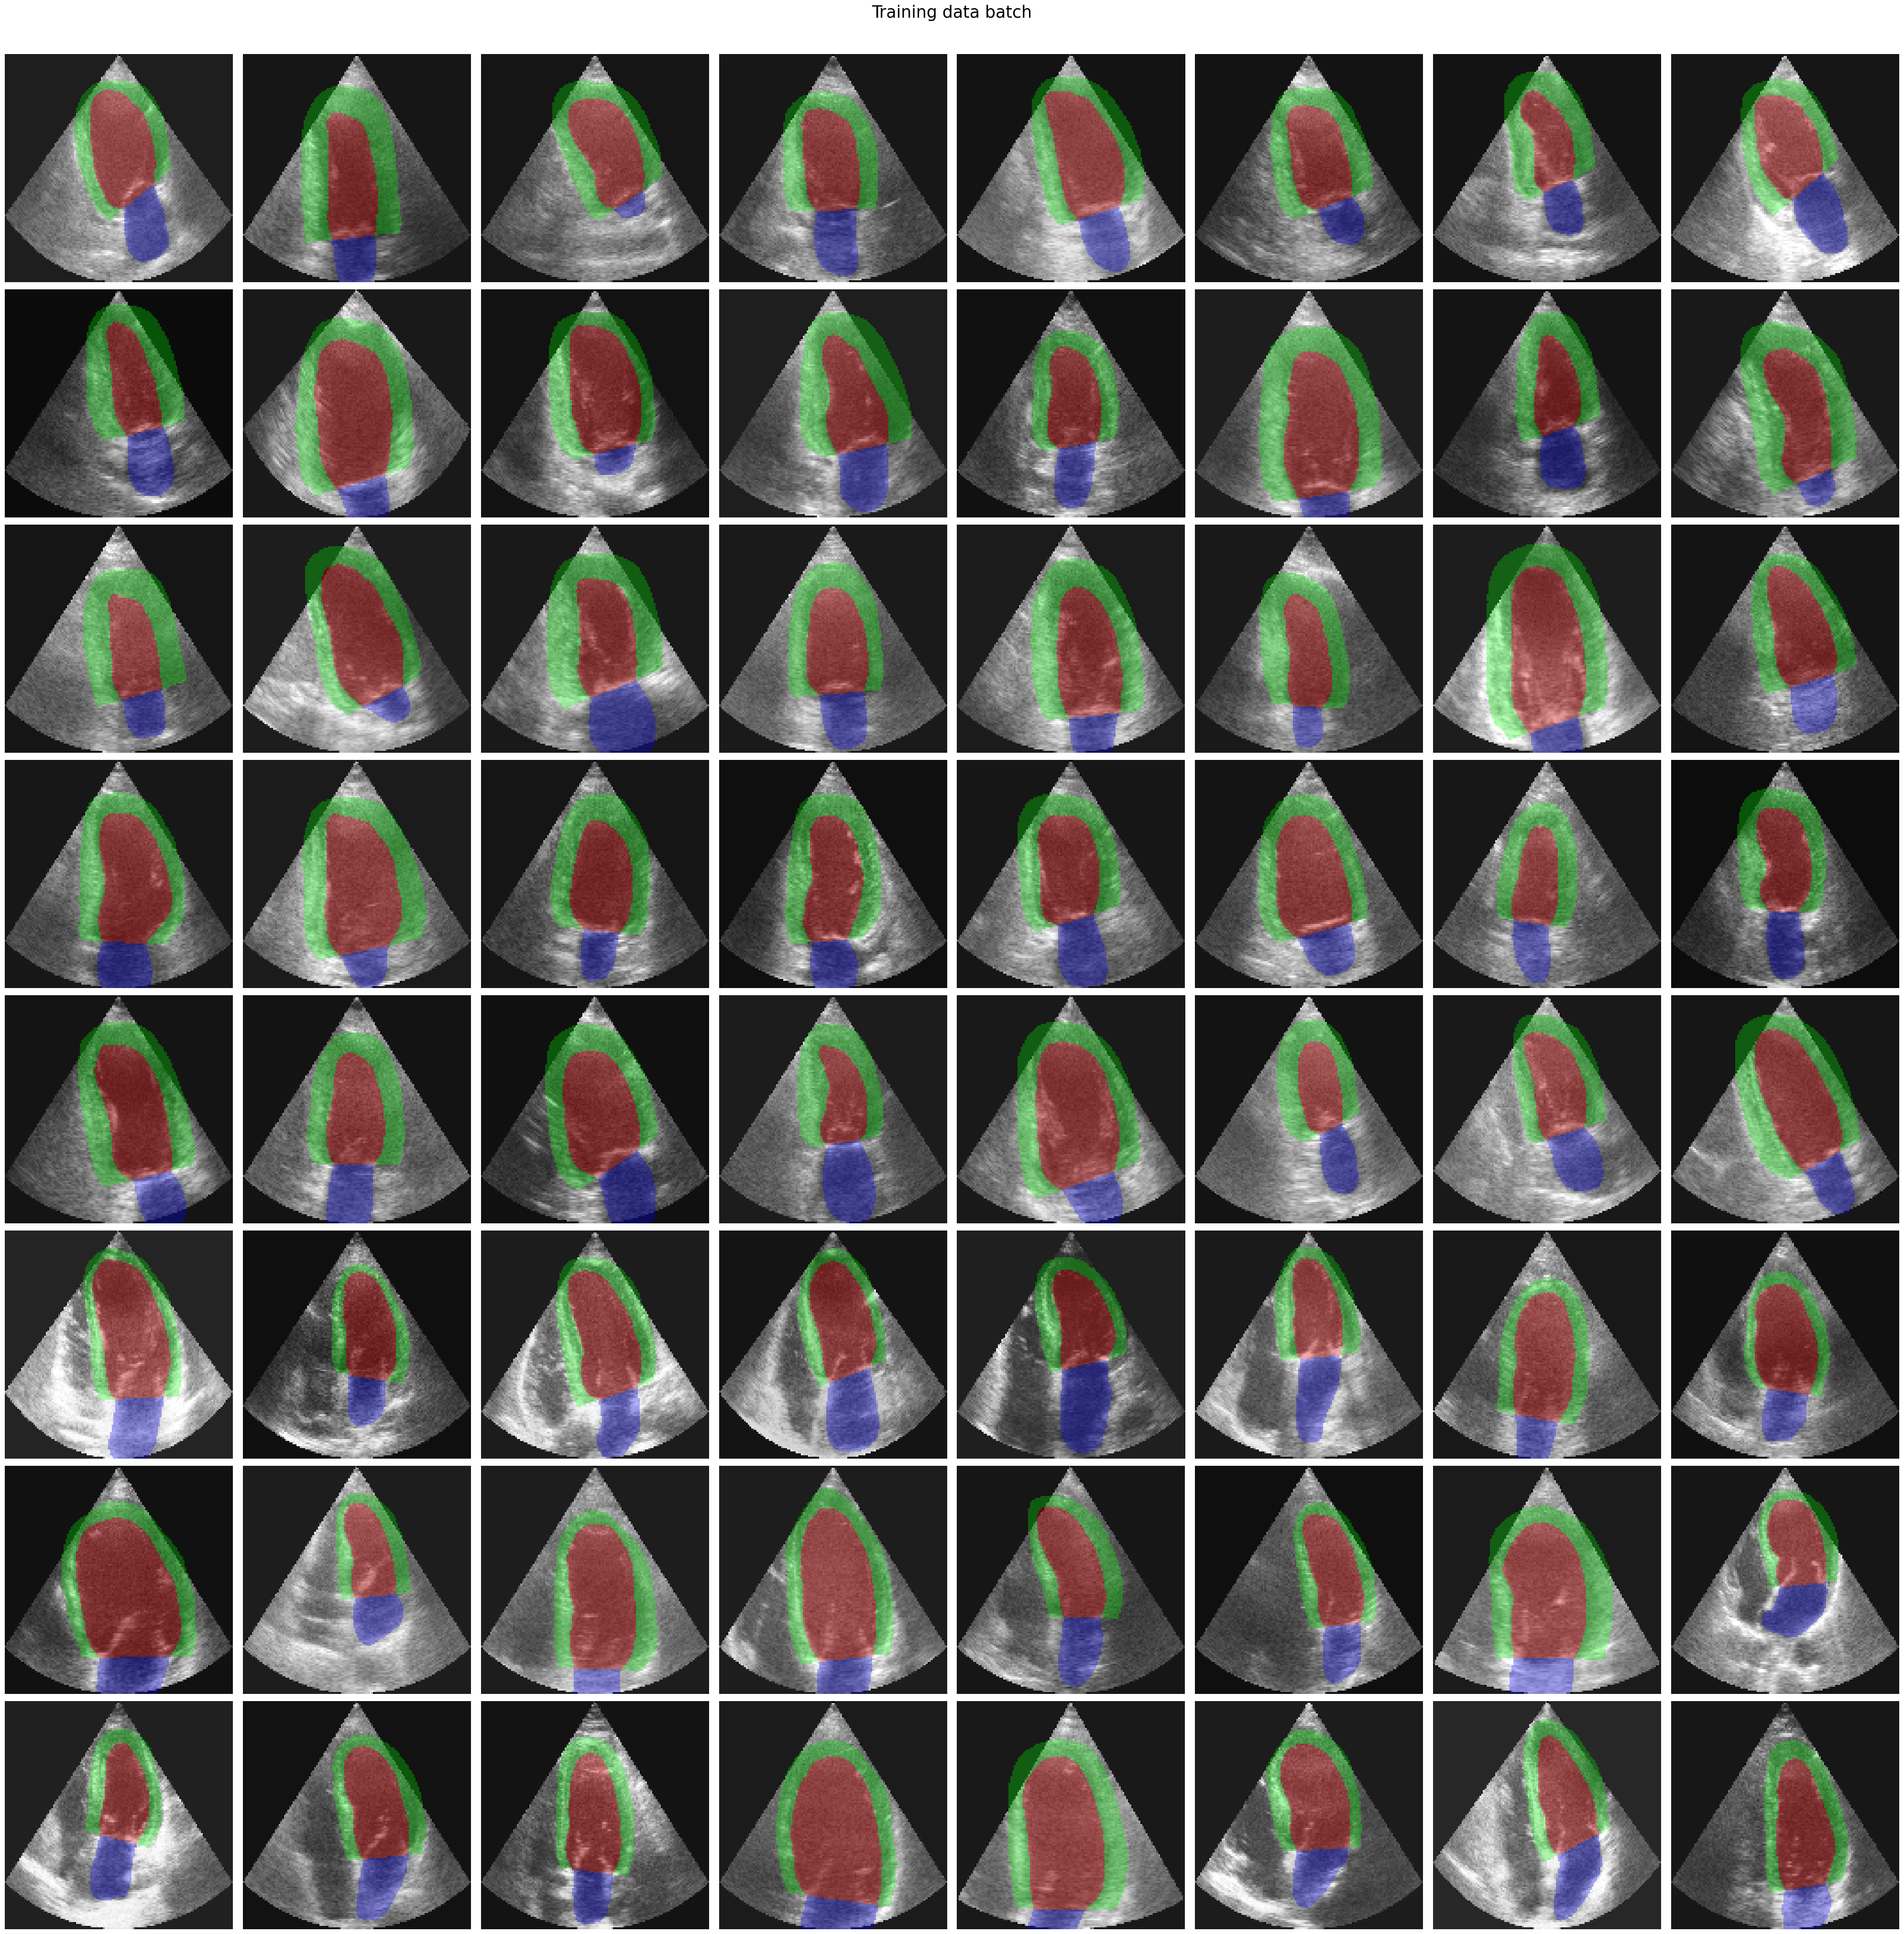

In [109]:
# Take one batch from the dataset
for img, mask in train_dataset.take(1):

    # Plot each image with its corresponding mask
    n = np.ceil(np.sqrt(BATCH_SIZE)).astype(int)
    fig, axes = plt.subplots(n, n, figsize=(5*n, 5*n))  # (n x n) grid

    for i, ax in enumerate(axes.ravel()):
        ax.imshow(img[i, ...], cmap='gray')
        ax.imshow(to_categorical(mask[i]), cmap=cmap) # Overlay mask with transparency
        ax.axis('off')

plt.suptitle('Training data batch', fontsize=25, y=1.01)
plt.tight_layout()
plt.show()


## Define neural network architecture: U-Net
We will update our model architecture to a U-Net. This is a popular architecture for image segmentation tasks, and it has been shown to perform well on medical imaging tasks. The U-Net architecture consists of an encoder-decoder structure with skip connections between the encoder and decoder layers. This allows the model to learn both low-level and high-level features from the images.

The U-Net has previously been used successfully on the CAMUS dataset. If you read the original CAMUS paper by Leclerc et al (2019) you can find detailed information about how they implemented the U-Net architecture. The paper is available here: https://arxiv.org/pdf/1908.06948

The U-Net architecture is implemented in the code block below. The U-Net is very similar to the autoencoder architecture we used previously, but it has one key difference:The U-Net has skip connections between the encoder and decoder layers. This allows the model to learn both low-level and high-level features from the images. The skip connections are implemented by saving the output of each convolutional block in the encoder and concatenating it with the corresponding convolutional block in the decoder.

In addition, I doubled the amount of layers and added one extra level of downscaling/upscaling to increase the complexity and the number of parameters a bit. This should allow the model to learn more complex features from the images. The trade off is that it will take longer to train the model, and it will require more memory.

## Define custom loss function: Dice loss
In this challenge we are trying to get as high dice score as possible. Therefore, it could be a good idea to use the dice score as a loss function, as the model will them optimize directly for the metric we care about. We can define our dice loss using our dice metric we defined earlier. Note that: 1) we need the loss to be negative, since we want to minimize the loss, and 2) we need to add a *function decorator* which makes it possible to save and load our model compiled with the custom loss.

In [110]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_false):
    return -dice(y_true, y_false) # Return negative dice score (since we want to minimize loss)


In [113]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define a CNN segmentation model (UNet)
def unet(input_shape):
    inputs = Input(shape=input_shape) # Defines input layer (shape: H x W x 1)

    # Downsampling
    # Connects input layer to a Conv-layer with 16 feature maps and 3x3 conv-kernels. Returns output connection in variable 'x'.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)  # output shape: H x W x 16
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)  # output shape: H x W x 16
    level_0 = x  # Save the output of this layer for later use
    x = MaxPooling2D((2, 2))(x) # Max-pooling layer with 2x2 kernel. Image dimensions are halved, leaving the maximum value from each 2x2 group of pixels.

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # output shape: H/2 x W/2 x 32
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # output shape: H/2 x W/2 x 32
    level_1 = x  # Save the output of this layer for later use
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/4 x W/4 x 64
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/4 x W/4 x 64
    level_2 = x  # Save the output of this layer for later use
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # output shape: H/8 x W/8 x 128
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # output shape: H/8 x W/8 x 128
    level_3 = x  # Save the output of this layer for later use
    x = MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) # output shape: H/16 x W/16 x 256
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) # output shape: H/16 x W/16 x 256

    # Upsampling
    x = UpSampling2D((2, 2))(x)
    x = concatenate([level_3, x]) # Concatenate with the corresponding encoder layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/8 x W/8 x 128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/8 x W/8 x 128

    x = UpSampling2D((2, 2))(x)
    x = concatenate([level_2, x]) # Concatenate with the corresponding encoder layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/4 x W/4 x 64
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/4 x W/4 x 64

    x = UpSampling2D((2, 2))(x)
    x = concatenate([level_1, x]) # Concatenate with the corresponding encoder layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # output shape: H/2 x W/2 x 32
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # output shape: H/2 x W/2 x 32

    x = UpSampling2D((2, 2))(x)
    x = concatenate([level_0, x]) # Concatenate with the corresponding encoder layer
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # output shape: H x W x 16
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # output shape: H x W x 16

    # Output layer (4 classes, softmax activation)
    outputs = Conv2D(4, (1, 1), activation='softmax')(x) # output shape: H x W x 4

    model = tf.keras.models.Model(inputs, outputs)
    return model

model = unet((*IMAGE_SIZE, 1))  # create new model
#model = tf.keras.models.load_model("./models/unet.keras")  # Load from file to use a model you've previously trained
model.name = 'LF-UNet'


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=dice_loss,  # use our custom dice loss
              metrics=[dice])  # Metrics other than loss to keep track of during training. Keeping track of the dice score (without background class) can be useful.
model.summary()

Model: "LF-UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_21[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 128) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8, 256) │    590,080 │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ conv2d_26[0][0],  │
│ (Concatenate)       │ 384)              │            │ up_sampling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │    221,248 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,591,300 (6.07 MB)

 Trainable params: 1,591,300 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

## Train your model
In the code cell where we train the model we make one important change: increasing the number of epochs.
Ideally, you should choose a number of epochs based on the *validation loss history*. You want to train until the validation loss stops decreasing (even if the training loss still decreases). At this point, the model has probably converged to the best possible performance you can get (given your model and hyperparameter settings). Training beyond this point might cause overfitting on the training data, leading to a worse performance on the validation and test sets (and an increase in validation loss).

We set the amount of epochs to 25. We can see from the loss curves that this is sufficient for the validation loss to converge.

In [114]:
EPOCHS = 25 # was 5

steps_per_epoch = int( np.ceil(N_TRAIN / BATCH_SIZE) ) # leave unchanged
validation_steps = int( np.ceil(N_VAL / BATCH_SIZE) ) # leave unchanged

history = model.fit(train_dataset.repeat(),
                    validation_data=val_dataset.repeat(),
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

os.makedirs('models', exist_ok=True)
model.save(f'./models/{model.name}.keras')
print('Model saved')

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 645ms/step - dice: 0.1311 - loss: -0.1311 - val_dice: 0.2668 - val_loss: -0.2664
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - dice: 0.2397 - loss: -0.2395 - val_dice: 0.3580 - val_loss: -0.3564
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - dice: 0.3839 - loss: -0.3838 - val_dice: 0.4929 - val_loss: -0.4907
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step - dice: 0.5056 - loss: -0.5055 - val_dice: 0.6088 - val_loss: -0.6074
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - dice: 0.6706 - loss: -0.6705 - val_dice: 0.7655 - val_loss: -0.7645
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - dice: 0.7728 - loss: -0.7727 - val_dice: 0.7701 - val_loss: -0.7689
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - dice: 0.7856 - loss: -0.7856 - val_dice: 0.7865 - val_loss: -0.7849
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - dice: 0.8108 - loss: -0.8108 - val_dice: 0.8107 - val_loss: -0.8100
Epoch 9/25
23/23 ━━

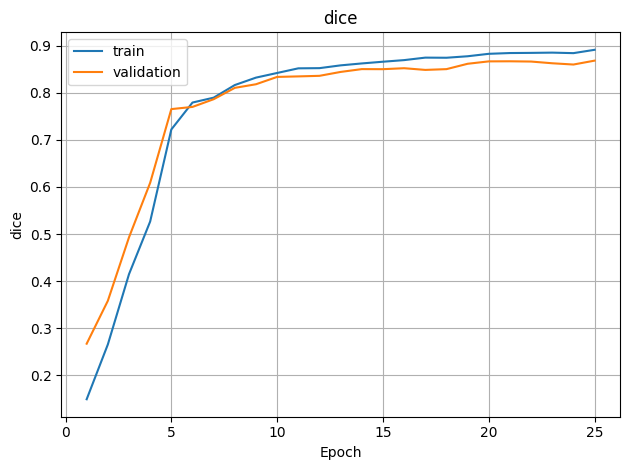

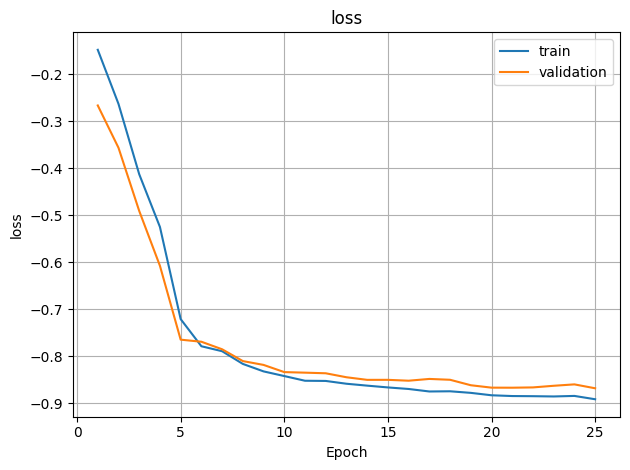

<Figure size 640x480 with 0 Axes>

In [115]:
for key in history.history.keys():
    if 'val_' in key:
        continue
    train_metric = history.history[key]
    val_metric = history.history['val_' + key]
    epochs = np.arange(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, label='train')
    plt.plot(epochs, val_metric, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()

    # Save history plots in 'plots' folder
    os.makedirs('./plots', exist_ok=True)
    plt.savefig(f'./plots/{model.name}_{key}.png')


## Evaluate the model performance
Now that our model is trained, we can use it to do *inference* on the ultrasound images, i.e. predict the segmentation masks. This we can do with model.predict().
In the cell below, we sample one batch from the test data generator and predict the segmentation masks for the batch of images. Then we visualize the results along with the reference masks. Run the cell multiple times to see different samples.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


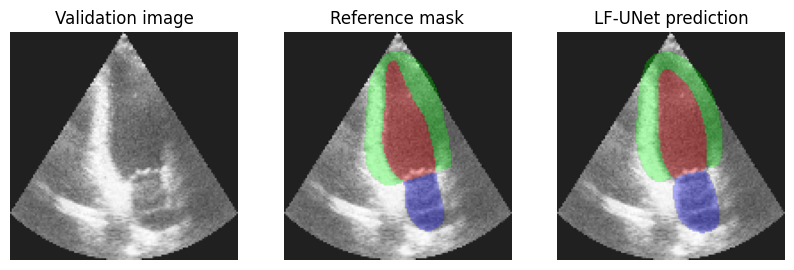

--- Evaluation of above image ---
Dice score (avg.): 0.8748
 -- Left ventricle: 0.8896
 -- Left ventricular wall: 0.8534
 -- Left atrium: 0.8813


In [117]:
iterator = iter(val_dataset)
img, mask = iterator.get_next() # Get random batch from test dataset

prediction = model.predict(img) # Predict segmentation masks from images

index = np.random.randint(BATCH_SIZE) # Index in batch

# Visualize results of selected image pair
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img[index, ..., 0], cmap='gray')
plt.title(f'Validation image')
plt.axis('off')
plt.subplot(132)
plt.imshow(img[index, ..., 0], cmap='gray')
plt.imshow(to_categorical(mask[index]), cmap=cmap)
plt.title('Reference mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(img[index, ..., 0], cmap='gray')
plt.imshow(to_categorical(prediction[index] > 0.5), cmap=cmap)
plt.title(f'{model.name} prediction')
plt.axis('off')
plt.show()

# Compute the dice score for each class for the selected image
dsc = dice(prediction, mask, axis=(1,2))
print(f'--- Evaluation of above image ---')
print(f'Dice score (avg.): {np.mean(dsc[index]):.4f}')
print(f' -- Left ventricle: {dsc[index,0]:.4f}')
print(f' -- Left ventricular wall: {dsc[index,1]:.4f}')
print(f' -- Left atrium: {dsc[index,2]:.4f}')



Seems like our model performs much better than it did to begin with :-)

### Evaluate on all images

Finally, we compute the average dice score for all the images in our test set. We obtain a single value which we can use to quantify the performance of our model. We can compare it to other models and then determine which has the better performance.

In this exercise, we only care about the dice score for simplicity.
But keep in mind that in the real world, the dice score alone does not tell you everything about how useful the model is.
There are other image segmentation metrics you could use as well. Moreover, in the end we care about *clinical measurements*, which are derived from the segmentation masks. To truly determine if your model is useful, you should therefore look at how it can be used for making clinical measurements and how it compares to real world clinical assessment. But that is for another time...

In [119]:
#model = tf.keras.models.load_model("./models/LF_UNet.keras")  # Load from file to use a model you've previously trained
dsc = tf.zeros(3)
n_batches = 0
# Iterate through batches in test set and compute dice score for every class
for img, mask in val_dataset:
    prediction = model.predict(img, verbose=0)
    dsc += dice(prediction, mask)
    n_batches += 1
dsc /= n_batches

print('--- Evaluation of entire validation dataset ---')
print(f'Dice score (avg.): {np.mean(dsc):.4f}')
print(f' -- Left ventricle: {dsc[0]:.4f}')
print(f' -- Left ventricular wall: {dsc[1]:.4f}')
print(f' -- Left atrium: {dsc[2]:.4f}')


--- Evaluation of entire validation dataset ---
Dice score (avg.): 0.8685
 -- Left ventricle: 0.9145
 -- Left ventricular wall: 0.8296
 -- Left atrium: 0.8615


The average dice score is decent, but there is still room for improvement. You can compare these results to the official CAMUS leaderboards here (average dice of 0.93-0.95): https://www.creatis.insa-lyon.fr/Challenge/camus/results.html

Keep in mind that our results are from evaluation on the *validation set*. The ones on the leaderboards are evaluated on the offical *test dataset*, which you do not have access to. If you submitted a trained model on blackboard you will be provided with your model's performance on the test set at a later time.